In [1]:
import cv2
import numpy as np

import seaborn
import sklearn.utils
import sklearn.metrics
import tensorflow as tf
from tensorflow import keras

from kaggle_datasets import KaggleDatasets

%matplotlib inline
import matplotlib.pyplot as plt

print("Tensorflow version " + tf.__version__)

2023-02-05 19:22:19.602378: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-05 19:22:19.602512: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version 2.4.1


# TPU

In [2]:
def load_TPU():
    # Detect TPU and return appropriate distribution strategy
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None
        print('No TPU. This program needs a TPU to work')

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        strategy = tf.distribute.get_strategy() 

    print("REPLICAS: ", strategy.num_replicas_in_sync)
    return strategy

# IMPORTING DATASET

In [3]:
BASE_DIR = KaggleDatasets().get_gcs_path("tpu-getting-started")+"/tfrecords-jpeg-192x192"
!gsutil ls $BASE_DIR
IMG_SIZE = 224 # 224 to use EfficientNet B0
NB_CLASSES = 104 # Number of differents flowers species we have


# Creates a dictionary describing the train features.
train_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'id': tf.io.FixedLenFeature([], tf.string),
    'class': tf.io.FixedLenFeature([], tf.int64),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, train_feature_description)

def preprocess_image(image):
    image = tf.io.decode_image(image, channels=3)
    return image

gs://kds-8442422a6b2b03bcb680bb99820271754ac8733633e09f2a369bcb23/tfrecords-jpeg-192x192/test/
gs://kds-8442422a6b2b03bcb680bb99820271754ac8733633e09f2a369bcb23/tfrecords-jpeg-192x192/train/
gs://kds-8442422a6b2b03bcb680bb99820271754ac8733633e09f2a369bcb23/tfrecords-jpeg-192x192/val/


## Import Train

2023-02-05 19:22:28.515784: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:22:28.585718: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-05 19:22:28.588040: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2023-02-05 19:22:28.588114: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-05 19:22:28.588155: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (e85585f045f4): /proc/driver/nvidia/version does not exist
2023-02-05 19:22:28.590449: I tensorflow/core/platform/cpu_feature_guard.cc:142] Th

label : 57


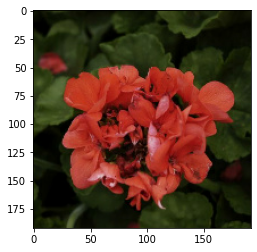

label : 10


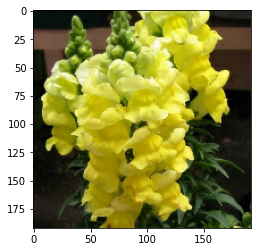

label : 82


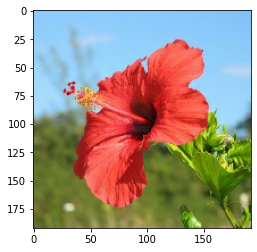

label : 102


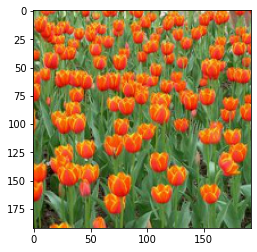

label : 94


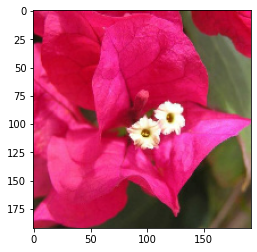

2023-02-05 19:22:31.530902: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:22:32.932536: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:22:34.274507: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:22:35.629775: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:22:36.843496: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


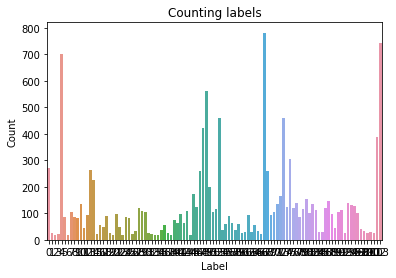

12753 train images found



In [4]:
labels_train=[]
images_train=[]

counter=0
max = 5 # Number of images we want to display

list_files_train=tf.io.gfile.glob(BASE_DIR + '/train/*.tfrec')

# We load all train data and show some examples
for file in list_files_train:
    for img in tf.data.TFRecordDataset(file).map(_parse_image_function):
        counter += 1

        labels_train.append(img['class'].numpy())

        image_raw = preprocess_image(img['image'])
        image_raw_int = image_raw.numpy()  
        image_compressed=cv2.resize(image_raw_int,(IMG_SIZE,IMG_SIZE))
        images_train.append(image_compressed)

        if(counter<=max):
          image_raw = preprocess_image(img['image'])
          image_raw_int = image_raw.numpy()

          print("label : " + str(img['class'].numpy()))
          plt.imshow(image_raw_int)
          plt.show()


seaborn.countplot(x=labels_train)
plt.title("Counting labels")
plt.ylabel("Count")
plt.xlabel("Label")
plt.show()

print(str(len(labels_train)) + " train images found\n")

## Import validation

2023-02-05 19:22:52.443711: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:22:52.559948: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:22:53.118664: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:22:53.583896: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:22:54.049766: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


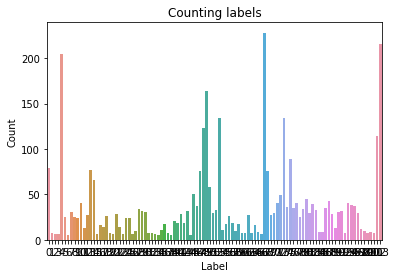

3712 validation images found



In [5]:
labels_val=[]
images_val=[]

list_files_val=tf.io.gfile.glob(BASE_DIR + '/val/*.tfrec')

for file in list_files_val:
    for img in tf.data.TFRecordDataset(file).map(_parse_image_function):

        labels_val.append(img['class'].numpy())

        image_raw = preprocess_image(img['image'])
        image_raw_int = image_raw.numpy()
        image_compressed=cv2.resize(image_raw_int,(IMG_SIZE,IMG_SIZE))
        images_val.append(image_compressed)


seaborn.countplot(x=labels_val)
plt.title("Counting labels")
plt.ylabel("Count")
plt.xlabel("Label")
plt.show()

print(str(len(images_val)) + " validation images found\n")

## Import Test

In [6]:
images_test=[]
images_test_id=[]

test_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'id': tf.io.FixedLenFeature([], tf.string),
}

def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, test_feature_description)

list_files_test=tf.io.gfile.glob(BASE_DIR + '/test/*.tfrec')

for file in list_files_test:
    for img in tf.data.TFRecordDataset(file).map(_parse_image_function):

        images_test_id.append(img['id'].numpy())

        image_raw = preprocess_image(img['image'])
        image_raw_int = image_raw.numpy()
        image_compressed=cv2.resize(image_raw_int,(IMG_SIZE,IMG_SIZE))
        images_test.append(image_compressed)


print(str(len(images_test)) + " test images found\n")

2023-02-05 19:23:01.650360: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:23:01.796520: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:23:02.614670: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:23:03.408134: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2023-02-05 19:23:04.199211: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


7382 test images found



# BUILDING AND TRAINING MODEL

## Metrics

In [7]:
# Displaying training metrics
def plot_metrics(history) -> None:
  plt.plot(training.history["accuracy"])
  plt.plot(training.history["val_accuracy"])
    
  plt.title("Model's accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epoch")
  plt.legend(["Training", "Validation"], loc="upper left")
  plt.show()

  plt.plot(training.history["loss"])
  plt.plot(training.history["val_loss"])
  plt.title("Model's loss")
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.legend(["Training", "Validation"], loc="upper right")
  plt.show()

## Transfer-Learning EfficientNet

In [8]:
#Transfer learning using the EfficientNet model

from tensorflow.keras.applications import EfficientNetB0

with load_TPU().scope():
    conv_base = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=NB_CLASSES)

    modelEFFICIENT = keras.models.Sequential()
    modelEFFICIENT.add(conv_base)
    modelEFFICIENT.add(keras.layers.GlobalMaxPooling2D(name="gap"))
    
    #avoid overfitting
    modelEFFICIENT.add(keras.layers.Dropout(rate=0.2, name="dropout_out"))
    modelEFFICIENT.add(keras.layers.Dense(NB_CLASSES, activation="softmax", name="fc_out"))
    conv_base.trainable = False

    modelEFFICIENT.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    
modelEFFICIENT.summary()

Running on TPU  grpc://10.0.0.2:8470


2023-02-05 19:23:15.205715: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-05 19:23:15.228151: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-02-05 19:23:15.228205: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2023-02-05 19:23:15.243300: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-02-05 19:23:15.243365: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2023-02-05 19:23:15.243967: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30019


REPLICAS:  8
16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 104)               133224    
Total params: 4,182,795
Trainable params: 133,224
Non-trainable params: 4,049,571
_________________________________________________________________


2023-02-05 19:23:35.084570: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1919683584 exceeds 10% of free system memory.


Epoch 1/30
100/100 [==============================] - 30s 161ms/step - loss: 6.1501 - accuracy: 0.1699 - val_loss: 1.9143 - val_accuracy: 0.5762
Epoch 2/30
100/100 [==============================] - 4s 36ms/step - loss: 2.1162 - accuracy: 0.5515 - val_loss: 1.4071 - val_accuracy: 0.6794
Epoch 3/30
100/100 [==============================] - 4s 38ms/step - loss: 1.4697 - accuracy: 0.6565 - val_loss: 1.2342 - val_accuracy: 0.7214
Epoch 4/30
100/100 [==============================] - 4s 37ms/step - loss: 1.2064 - accuracy: 0.7103 - val_loss: 1.1841 - val_accuracy: 0.7441
Epoch 5/30
100/100 [==============================] - 4s 36ms/step - loss: 0.9961 - accuracy: 0.7504 - val_loss: 1.0953 - val_accuracy: 0.7589
Epoch 6/30
100/100 [==============================] - 4s 36ms/step - loss: 0.8414 - accuracy: 0.7733 - val_loss: 1.1509 - val_accuracy: 0.7505
Epoch 7/30
100/100 [==============================] - 4s 36ms/step - loss: 0.7612 - accuracy: 0.7965 - val_loss: 1.0463 - val_accuracy: 0.77

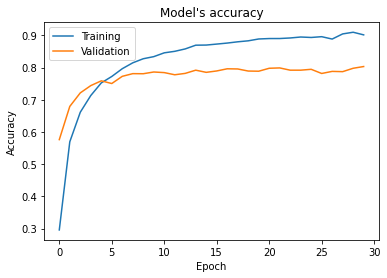

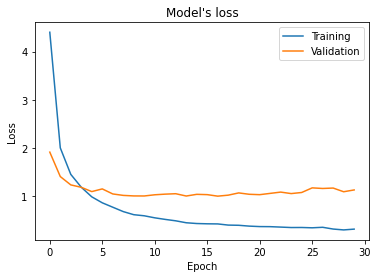

In [9]:
training = modelEFFICIENT.fit(np.array(images_train), np.array(labels_train), epochs=30, batch_size=128, validation_data=(np.array(images_val), np.array(labels_val)))

plot_metrics(training.history)

## EVALUATING SCORE

### This part is dedicated to the model's results, precisely validation accuracy and validation macro F1 score

In [10]:
modelEFFICIENT.evaluate(np.array(images_val), np.array(labels_val), verbose=1)

val_pred = modelEFFICIENT.predict(np.array(images_val)).round()
val_pred = np.argmax(val_pred, axis=1)

print('F1 score : '+ str(sklearn.metrics.f1_score(labels_val,val_pred, average='macro')))

116/116 [==============================] - 9s 20ms/step - loss: 1.1295 - accuracy: 0.8031
F1 score : 0.7866973474787724


## EXPORTING TEST PREDICTIONS

In [11]:
test_pred = modelEFFICIENT.predict(np.array(images_test)).round()
test_pred = np.argmax(test_pred, axis=1)

export_dict = dict(zip(images_test_id, test_pred)) # Creates a dictionary mapping the id and the predicted labels together

In [12]:
import csv
csv_columns = ['id','label']
csv_file = "submission.csv"

try:
    with open(csv_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(csv_columns)
        
        for row in export_dict.items():
            writer.writerow(row)
        print(csv_file+' created')
except IOError:
    print("I/O error")

submission.csv created
